In [1]:
import pandas as pd
import sqlite3

#Load CSV - by importing the CSV into a pandas DataFrame
df=pd.read_csv('inventory_forecasting.csv')

#Preview df
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0096,Toys,West,158,134,142,152.36,40.88,5,Sunny,1,42.39,Winter
1,2022-01-01,S001,P0016,Clothing,East,189,127,125,150.47,90.78,0,Rainy,0,84.16,Winter
2,2022-01-01,S001,P0031,Electronics,West,75,48,39,68.62,13.99,20,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0159,Electronics,West,161,74,71,75.46,84.92,10,Snowy,0,83.03,Winter
4,2022-01-01,S001,P0129,Furniture,South,135,66,69,67.18,19.66,0,Cloudy,0,20.55,Winter


In [2]:
#To check for null values
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [3]:
#Rename columns to SQL-friendly format
df.columns=[c.strip().replace(' ','_').replace('/','_') for c in df.columns]

df.columns

Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion',
       'Competitor_Pricing', 'Seasonality'],
      dtype='object')

In [4]:
#Create in-memory SQLite DB
conn=sqlite3.connect('retail.db')

#Write table to SQLite, named 'InventoryData'
df.to_sql('InventoryData',conn,if_exists='replace',index=False)

109500

In [7]:
gquery_1="""
SELECT distinct Category FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category
0,Toys
1,Clothing
2,Electronics
3,Furniture
4,Groceries


In [8]:
gquery_1="""
SELECT DISTINCT Category,Product_ID
FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category,Product_ID
0,Toys,P0096
1,Clothing,P0016
2,Electronics,P0031
3,Electronics,P0159
4,Furniture,P0129
5,Furniture,P0116
6,Electronics,P0070
7,Electronics,P0171
8,Electronics,P0175
9,Clothing,P0046


In [25]:

gquery_2 = """
SELECT 
    Store_ID,

    -- Electronics KPIs
    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END), 0) AS Electronics_Order_Sales_Ratio,

    -- Grocery KPIs
    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END), 0) AS Grocery_Order_Sales_Ratio,

    -- Clothing KPIs
    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END), 0) AS Clothing_Order_Sales_Ratio,

    -- Furniture KPIs
    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END), 0) AS Furniture_Order_Sales_Ratio,

        -- Toys KPIs
    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END), 0) AS Toys_Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID;
"""

df_kpi_by_store = pd.read_sql_query(gquery_2, conn)
df_kpi_by_store.describe()

,Electronics_Sell_Through_Rate,Electronics_Inventory_Turnover,Electronics_Order_Sales_Ratio,Grocery_Sell_Through_Rate,Grocery_Inventory_Turnover,Grocery_Order_Sales_Ratio,Clothing_Sell_Through_Rate,Clothing_Inventory_Turnover,Clothing_Order_Sales_Ratio,Furniture_Sell_Through_Rate,Furniture_Inventory_Turnover,Furniture_Order_Sales_Ratio,Toys_Sell_Through_Rate,Toys_Inventory_Turnover,Toys_Order_Sales_Ratio
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.643242,14086.997461,0.993837,0.671436,14704.458140,0.995051,0.681740,14930.111446,0.997181,0.655876,14363.676230,0.994819,0.656019,14366.809837,0.995834
std,0.001572,34.431355,0.001427,0.005520,120.897629,0.001941,0.000922,20.192154,0.001563,0.003346,73.272254,0.001984,0.004465,97.794103,0.002952
min,0.640984,14037.550535,0.991675,0.665845,14582.011837,0.992473,0.680320,14899.008413,0.995836,0.650973,14256.317924,0.991541,0.651030,14257.555424,0.992026
25%,0.642635,14073.706275,0.993211,0.666414,14594.462374,0.993477,0.681313,14920.757799,0.996307,0.655193,14348.723071,0.994944,0.651230,14261.939521,0.994189
50%,0.643149,14084.972166,0.994203,0.670816,14690.877612,0.996116,0.682166,14939.441085,0.996715,0.655276,14350.543654,0.995055,0.659125,14434.845250,0.995739
75%,0.644579,14116.283401,0.994957,0.676072,14805.966058,0.996436,0.682382,14944.172573,0.997225,0.658338,14417.598233,0.995700,0.659208,14436.647102,0.997545
max,0.644862,14122.474926,0.995139,0.678035,14848.972820,0.996752,0.682520,14947.177362,0.999823,0.659598,14445.198270,0.996854,0.659501,14443.061889,0.999670


In [34]:
gquery_3 = """
SELECT 
    Store_ID,
    Product_ID,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

    SUM(Units_Ordered) * 1.0 / 
    NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID, Product_ID;
"""
df_kpi_by_product = pd.read_sql_query(gquery_3, conn)
df_kpi_by_product.describe()


,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio
count,150.000000,150.000000,150.000000
mean,0.663062,484.035517,0.995532
std,0.017167,12.532216,0.004898
min,0.630336,460.145460,0.982593
25%,0.648485,473.393798,0.992798
50%,0.661748,483.076100,0.995296
75%,0.679095,495.739337,0.998287
max,0.695294,507.564283,1.008378


In [35]:
gquery_4 = """
SELECT *
FROM (
    SELECT 
        Store_ID,
        Product_ID,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

        SUM(Units_Ordered) * 1.0 / 
        NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

    FROM InventoryData
    GROUP BY Store_ID, Product_ID
) AS sub
WHERE Order_Sales_Ratio > 1.02 OR Order_Sales_Ratio < 0.98;
"""

df_kpi_anom_2per = pd.read_sql_query(gquery_4, conn)
df_kpi_anom_2per


,Store_ID,Product_ID,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio


In [ ]:
#Current Stock per Product per Store
query1_storewise = """
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
"""
pd.read_sql_query(query1_storewise, conn)

,Product_ID,Store_ID,Inventory_Level
0,P0016,S001,111
1,P0016,S002,277
2,P0016,S003,228
3,P0016,S004,248
4,P0016,S005,240
...,...,...,...
145,P0187,S001,245
146,P0187,S002,115
147,P0187,S003,193
148,P0187,S004,130


In [ ]:
#Low Inventory Detection, triggering a restock alert
query2= """
SELECT Date, Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date;
"""
pd.read_sql_query(query2, conn)

,Date,Product_ID,Store_ID,Inventory_Level
0,2022-01-01,P0116,S001,53
1,2022-01-01,P0067,S001,101
2,2022-01-01,P0017,S001,70
3,2022-01-01,P0016,S002,210
4,2022-01-01,P0129,S002,87
...,...,...,...,...
16267,2023-12-31,P0126,S004,67
16268,2023-12-31,P0171,S005,139
16269,2023-12-31,P0187,S005,195
16270,2023-12-31,P0153,S005,87


In [ ]:
#7-Day Rolling Average
#Approximates product demand
query3="""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales
FROM InventoryData
WHERE Date>=(
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
"""
pd.read_sql_query(query3, conn)

,Product_ID,Avg_7Day_Sales
0,P0016,135.89
1,P0133,133.94
2,P0187,133.60
3,P0125,132.31
4,P0057,132.17
5,P0061,127.77
6,P0126,127.74
7,P0066,127.51
8,P0178,123.03
9,P0046,121.80


In [ ]:
#Inventory Turnover
#High turnover=fast-moving product, constantlu restocking
query4="""
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
"""
pd.read_sql_query(query4, conn)

,Product_ID,Total_Sales,Avg_Inventory,Inventory_Turnover
0,P0046,386805,154.506301,2503.49
1,P0133,385843,154.356986,2499.68
2,P0057,387209,155.087945,2496.71
3,P0178,384440,153.986575,2496.58
4,P0187,385583,154.869315,2489.73
5,P0066,384764,154.667123,2487.69
6,P0125,385137,154.882192,2486.64
7,P0061,384668,154.775342,2485.33
8,P0069,382968,154.473151,2479.19
9,P0016,384509,155.221096,2477.17


In [ ]:
#Ranks products by average daily sales volume
query5 = """
SELECT Product_ID,
       AVG(Units_Sold) AS Avg_Sales_Per_Day
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
"""
pd.read_sql_query(query5, conn)

,Product_ID,Avg_Sales_Per_Day
0,P0057,106.084658
1,P0046,105.973973
2,P0133,105.710411
3,P0187,105.639178
4,P0125,105.516986
5,P0066,105.414795
6,P0061,105.388493
7,P0016,105.344932
8,P0178,105.326027
9,P0069,104.922740


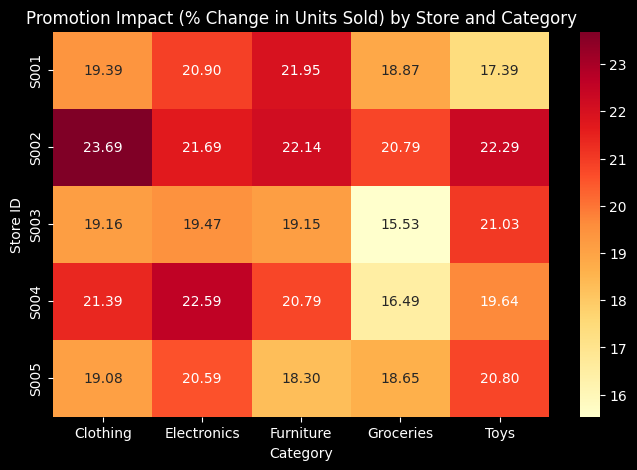

In [65]:
import seaborn as sns

query6 = """
SELECT Store_ID,Category,
       AVG(Units_Sold) AS Avg_Units_Sold,
       100*(AVG(CASE WHEN Holiday_Promotion = 1 THEN units_sold END)-
       AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END))/ AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END) AS Percentage_Change_Between_Promotions
FROM InventoryData
GROUP BY Store_ID,Category 
ORDER BY Percentage_Change_Between_Promotions DESC;
"""
df_kpi_by_promotions = pd.read_sql_query(query6, conn)
df_kpi_by_promotions_cat = df_kpi_by_promotions.pivot(index='Store_ID', columns='Category', values='Percentage_Change_Between_Promotions')
plt.figure(figsize=(8, 5))
sns.heatmap(df_kpi_by_promotions_cat, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Promotion Impact (% Change in Units Sold) by Store and Category")
plt.ylabel("Store ID")
plt.xlabel("Category")
plt.show()

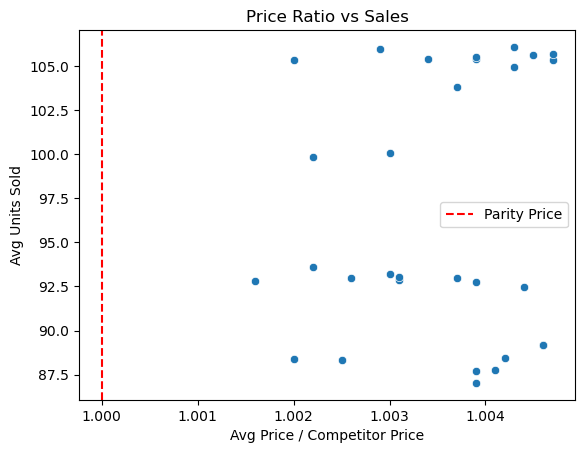

In [ ]:
#Price Competitivness vs Sales
#Analyzes whether being cheaper correlates with more units solds
import seaborn as sns
import matplotlib.pyplot as plt

query7a= """
SELECT Product_ID,
       ROUND(AVG(Price / Competitor_Pricing), 4) AS Avg_Price_Ratio,
       AVG(Units_Sold) AS Avg_Units_Sold
FROM InventoryData
WHERE Competitor_Pricing > 0
GROUP BY Product_ID;
"""
df_price_effect = pd.read_sql_query(query7a, conn)

sns.scatterplot(data=df_price_effect, x='Avg_Price_Ratio', y='Avg_Units_Sold')
plt.axvline(1, color='red', linestyle='--', label='Parity Price')
plt.title('Price Ratio vs Sales')
plt.xlabel('Avg Price / Competitor Price')
plt.ylabel('Avg Units Sold')
plt.legend()
plt.show()

All products are priced above competitor levels.This may explain suboptimal sales performance for some SKUs.We reccomend dynamic pricing analysis.

In [56]:
#Price Bucket Breakdown
query7b = """
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN '🟢 Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN '🟡 Moderately Higher (5–20%)'
    ELSE '🔴 Significantly Higher (>20%)'
  END AS Price_Positioning,

  COUNT(*) AS Num_Products,
  ROUND(AVG(Avg_Units_Sold), 2) AS Avg_Units_Sold

FROM ProductRatios
GROUP BY Price_Positioning
ORDER BY Price_Positioning;
"""

pd.read_sql_query(query7b, conn)

,Price_Positioning,Num_Products,Avg_Units_Sold
0,🟢 Slightly Higher (≤5%),30,96.72


In [60]:
#Forecast Accuracy
query8 = """
SELECT Product_ID,
       100*ROUND(AVG(ABS(Units_Sold - Demand_Forecast)/Units_Sold), 4) AS Avg_Forecast_Error
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error DESC;
"""
pd.read_sql_query(query8, conn)

,Product_ID,Avg_Forecast_Error
0,P0079,16.15
1,P0031,16.13
2,P0085,16.09
3,P0187,16.08
4,P0183,15.99
5,P0094,15.95
6,P0046,15.95
7,P0069,15.94
8,P0017,15.93
9,P0149,15.90




**Python** **Forecasting**


In [61]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3

c:\MY FILES\Coding\SQL\proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Import libraries needed for forecasting

We’ll use Prophet for time series, Random Forest for machine learning, and pandas for data handling.

In [62]:
# Load data for top 5 products from SQLite 
#to build the forecasting pipeline
query_top_products = """
SELECT Product_ID, SUM(Units_Sold) AS Total_Units
FROM InventoryData
GROUP BY Product_ID
ORDER BY Total_Units DESC
LIMIT 5;
"""

top_products = pd.read_sql_query(query_top_products, conn)['Product_ID'].tolist()
top_products

['P0057', 'P0046', 'P0133', 'P0187', 'P0125']

In [63]:
def forecast_for_product(product_id, conn):
    # 1. Load data
    query = f"""
    SELECT Date, Product_ID, Units_Sold, Demand_Forecast, Price, Competitor_Pricing,
           Discount, Holiday_Promotion, Inventory_Level
    FROM InventoryData
    WHERE Product_ID = '{product_id}'
    ORDER BY Date;
    """
    df = pd.read_sql_query(query, conn)
    if len(df) < 30:
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2. Feature engineering
    df['Lag_1'] = df['Units_Sold'].shift(1)
    df['Lag_7'] = df['Units_Sold'].shift(7)
    df['Rolling_7'] = df['Units_Sold'].rolling(7).mean()
    df['Price_Ratio'] = df['Price'] / df['Competitor_Pricing']
    df['Promo_Flag'] = (df['Holiday_Promotion'] == 'Yes').astype(int)
    df = df.dropna()

    if df.shape[0] < 21:
        return None

    # 3. Train Random Forest model
    features = ['Lag_1', 'Lag_7', 'Rolling_7', 'Price_Ratio', 'Promo_Flag']
    X = df[features]
    y = df['Units_Sold']
    X_train, X_test = X[:-14], X[-14:]
    y_train = y[:-14]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # 4. Prophet model(Time-Series)
    df_prophet = df[['Date', 'Units_Sold']].rename(columns={'Date': 'ds', 'Units_Sold': 'y'})
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=14)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].tail(14).reset_index(drop=True)

    # 5. Blend
    blended_df = df[['Date']].iloc[-14:].reset_index(drop=True)
    blended_df['RF_Pred'] = rf_pred
    blended_df['Prophet_Pred'] = prophet_pred['yhat']
    blended_df['Blended_Forecast'] = 0.7 * rf_pred + 0.3 * prophet_pred['yhat']
    blended_df['Date'] = prophet_pred['ds']
    blended_df['Product_ID'] = product_id

    # 6. Reorder logic
    blended_df['Safety_Stock'] = 0.1 * blended_df['Blended_Forecast'] #buffer
    blended_df['Required_Inventory'] = blended_df['Blended_Forecast'] + blended_df['Safety_Stock']
    current_inventory = df['Inventory_Level'].iloc[-1]
    blended_df['Reorder_Qty'] = (blended_df['Required_Inventory'] - current_inventory).clip(lower=0).round()

    return blended_df[['Product_ID', 'Date', 'Blended_Forecast', 'Reorder_Qty']]


Forecast Function

Reusable forecasting logic for each product: SQL → Features → ML + Prophet → Reorder


In [64]:
#Loop over top 5 products
#calculate the Reorder quantity
all_forecasts = []

for pid in top_products:
    print(f"Processing {pid}...")
    result = forecast_for_product(pid, conn)
    if result is not None:
        all_forecasts.append(result)

forecast_results = pd.concat(all_forecasts, ignore_index=True)
forecast_results.head()

Processing P0057...


10:11:34 - cmdstanpy - INFO - Chain [1] start processing
10:11:35 - cmdstanpy - INFO - Chain [1] done processing


Processing P0046...


10:11:36 - cmdstanpy - INFO - Chain [1] start processing
10:11:36 - cmdstanpy - INFO - Chain [1] done processing


Processing P0133...


10:11:37 - cmdstanpy - INFO - Chain [1] start processing
10:11:38 - cmdstanpy - INFO - Chain [1] done processing


Processing P0187...


10:11:39 - cmdstanpy - INFO - Chain [1] start processing
10:11:39 - cmdstanpy - INFO - Chain [1] done processing


Processing P0125...


10:11:40 - cmdstanpy - INFO - Chain [1] start processing
10:11:41 - cmdstanpy - INFO - Chain [1] done processing


,Product_ID,Date,Blended_Forecast,Reorder_Qty
0,P0057,2024-01-01,141.436735,29.0
1,P0057,2024-01-02,136.191824,23.0
2,P0057,2024-01-03,133.790452,20.0
3,P0057,2024-01-04,135.402552,22.0
4,P0057,2024-01-05,141.922621,29.0
